In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dem_stitcher.stitcher import stitch_dem
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np
import pandas as pd
import numpy as np

In [3]:
# Odessa Texas
bounds = [-103, 31, -101.5, 33] 
dem_0 = 'glo_30'
dem_1 = 'nasadem'
ellipsoidal_hgt = True

# Loading the 1st DEM

In [4]:
%%time

X_0, p_0 = stitch_dem(bounds, 
                      dem_0, 
                      # More than 5 workers can cause timeout errors.
                      n_threads_downloading=5,
                      dst_ellipsoidal_height=ellipsoidal_hgt)
p_0

Reading glo_30 Datasets: 100%|██| 12/12 [00:16<00:00,  1.37s/it]


CPU times: user 8.23 s, sys: 3.87 s, total: 12.1 s
Wall time: 2min 36s


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 5401, 'height': 7201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -103.0,
       0.0, -0.0002777777777777778, 33.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

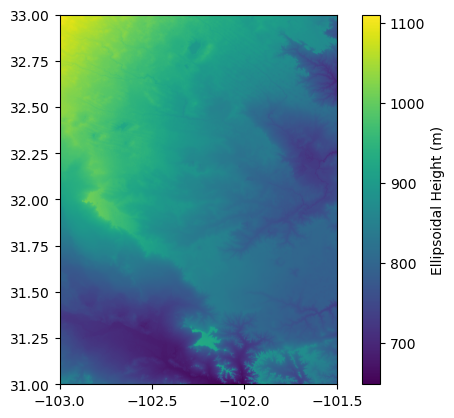

In [5]:
# source https://stackoverflow.com/a/70334691
fig, ax = plt.subplots()
data = plot.show(X_0, transform=p_0['transform'], ax=ax)
im = data.get_images()[0]
fig.colorbar(im, label='Ellipsoidal Height (m)', ax=ax)

# Loading the 2nd DEM

In [8]:
%%time

X_1, p_1 = stitch_dem(bounds, 
                      dem_1, 
                      # More than 5 workers can cause timeout errors.
                      n_threads_downloading=5,
                      dst_ellipsoidal_height=ellipsoidal_hgt)
p_1

CPU times: user 6.07 s, sys: 2.35 s, total: 8.42 s
Wall time: 34.2 s


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 5401, 'height': 7201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -103.0,
       0.0, -0.0002777777777777778, 33.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

# Comparison

We first have to reproject the two DEMs into the same frame; although they were called using the same bounds, dem-stitcher aligns to |the original pixel resolution.

In [9]:
X_1_r, _ = reproject_arr_to_match_profile(X_1, p_1, p_0, resampling='bilinear')
X_1_r = X_1_r[0, ...]

We get the qualitative statistics of the difference of the two DEMs.

Text(0.5, 0, 'nasadem - glo_30 (m)')

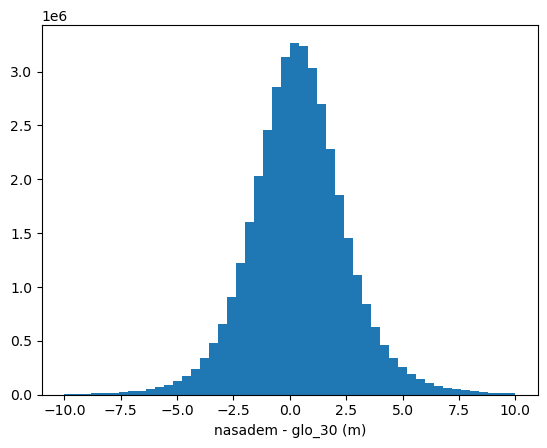

In [10]:
diff = (X_0 - X_1_r)
diff_r = diff[~np.isnan(diff)]
plt.hist(diff_r, bins=50, range=(-10, 10))
plt.xlabel(f'{dem_1} - {dem_0} (m)')

In [11]:
df = pd.DataFrame({'diff': diff_r})
df['diff_cm'] = np.round(df['diff'] * 100, 3)
df.drop(columns=['diff'], inplace=True)
df.describe()

,diff_cm
count,3.889260e+07
mean,3.821506e+01
std,2.245148e+02
min,-8.662451e+03
25%,-9.371900e+01
50%,3.479000e+01
75%,1.653630e+02
max,1.038404e+04


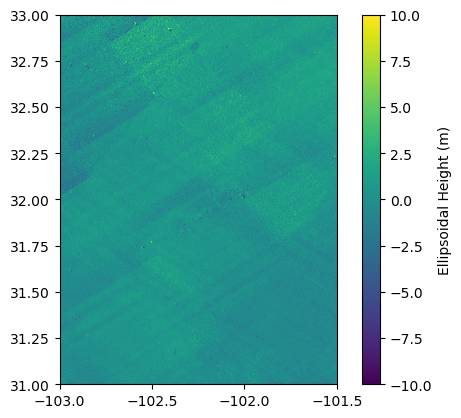

In [12]:
fig, ax = plt.subplots()
data = plot.show(diff, transform=p_0['transform'], ax=ax, vmin=-10, vmax=10)
im = data.get_images()[0]
fig.colorbar(im, label='Ellipsoidal Height (m)', ax=ax)